In [7]:
import locale
locale.setlocale(locale.LC_NUMERIC, 'C')
import sys
sys.path.append('/Users/nwilming/u')
sys.path.append('/Users/nwilming/libcmaes/python/')
%pylab
%matplotlib inline
import seaborn as sns
from conf_analysis.behavior import normative as nrm, fstnrm as fast
sns.set_style('ticks')
%load_ext autoreload
%autoreload 2
%aimport -fast

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/nwilming/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
from conf_analysis.behavior import variance_misperception as vm

In [9]:
from scipy.stats import norm, t
import pandas as pd

def make_samples(w, N=1000, vars=[.5, 1, 1.5], threshold=0.75, adaptive=True):
    dfs = []
    if not adaptive:
        s = concatenate([randn(5000)*v for v in vars])            
        center = t(*t.fit(s)).ppf(threshold)
    for v in vars:
        if adaptive:
            center = norm.ppf(threshold, loc=0, scale=v)
        s1 = randn(N/2)*v + center
        s2 = randn(N/2)*v - center
        con = concatenate((s1, s2))
        side = concatenate((s1*0+1, s2*0))
        noise = concatenate((s1*0+v, s2*0 + v))
        dfs.append(pd.DataFrame({'mc':con, 'noise_sigma':noise, 'contrast':con*0 + center, 'side':side}))
    df =pd.concat(dfs)
    lpr = vm.logPR(w, df.mc, df.noise_sigma, df.contrast, vars)
    df.loc[:, 'choice'] = df['mc']>0
    df.loc[:, 'correct'] = df.choice == df.side
    df.loc[:, 'confidence'] = abs(lpr)>1.
    df.loc[:, 'snum']=1
    df.loc[:, 'lpr'] = lpr
    return df


In [10]:
df = make_samples(0, N=500, adaptive=True)
print df.correct.mean()

0.752


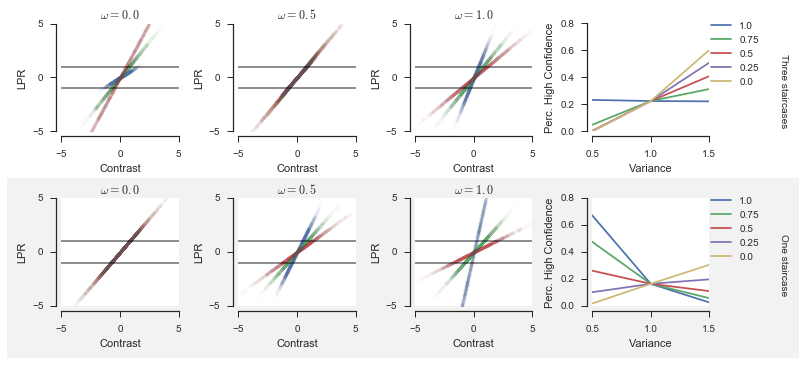

In [11]:
gs = matplotlib.gridspec.GridSpec(2, 4)
figure(figsize=(10, 5))
for j, a in enumerate([True, False]):
    for i, w in enumerate([0, 0.5, 1]):
        subplot(gs[j, i])
        df = make_samples(w, N=2500, adaptive=a)
        for _,c in df.groupby('noise_sigma'):
            plot(c.mc, c.lpr, '.', alpha=0.01)
        pyplot.locator_params(nbins=5)
        axhline(1, color='k', alpha=0.5)
        axhline(-1, color='k', alpha=0.5)
        xlabel('Contrast')
        ylabel('LPR')
        ylim([-5, 5])
        xlim([-5, 5])
        title(r'$\omega=%2.1f$'%w)

    subplot(gs[j, 3])
    for w in linspace(0,1.,5)[::-1]:
        l = vm.logPR(w, df.mc, df.noise_sigma, df.contrast, [0.5, 1., 1.5])
        df.loc[:, 'lpr'] = abs(l)>2
        plot(df.groupby('noise_sigma').lpr.mean(), label=w)
    xlabel('Variance')
    ylabel('Perc. High Confidence')
    legend(bbox_to_anchor=(1.5, 1.1))
    pyplot.locator_params(nbins=5)

sns.despine(offset=5)
tight_layout()

ax = gcf().add_axes([0,0, 1.1, .5])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_zorder(-1000)
ax.patch.set_alpha(0.05)
ax.patch.set_color('k')
text(0.975, 0.65, 'One staircase',  rotation=270)
text(0.975, 1.65, 'Three staircases',  rotation=270)
sns.despine(left=True, bottom=True, ax=ax)

savefig('/Users/nwilming/u/conf_analysis/plots/variance_model_staircase.pdf', bbox_inches='tight')

In [12]:
w, s, r, target, predicted = vm.explicit(df.confidence, df.correct, df.mc, df.side-.5, df.noise_sigma, df.side)

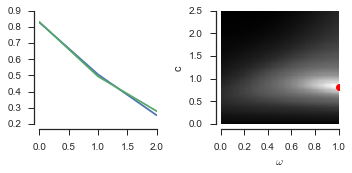

In [13]:
figure(figsize=(5, 2.5))
subplot(1,2,1)
plot(target)
plot(predicted)
subplot(1,2,2)
pcolor(w, s, log(r))
idx = argmin(r)
x, y = w.ravel()[idx], s.ravel()[idx]
plot(x, y, 'ro')
sns.despine(offset=5)
xlabel(r'$\omega$')
ylabel(r'c')
tight_layout()

In [14]:
import sys
sys.path.append('/Users/nwilming/u')
import cPickle
from conf_analysis.pupil import pupil, patsy_transforms as pt
from conf_analysis.behavior import empirical
from pylab import *
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
data = empirical.load_data()
data = empirical.data_cleanup(data)
def session_num(data):
    lt = dict((k, i) for i,k in enumerate(sort(unique(data.day))))
    data.loc[:, 'session_num'] = data.day
    data.session_num = data.session_num.replace(lt)
    return data

def block_num(data):
    lt = dict((k, i) for i,k in enumerate(sort(unique(data.session.astype('str')))))
    data.loc[:, 'block_num'] = data.session.astype('str')
    data.block_num = data.block_num.replace(lt)
    return data

data = data.groupby('snum').apply(session_num)
data = data.groupby(['snum', 'session_num']).apply(block_num)
def zscore_contrast(data):
    con = vstack(data.contrast_probe)
    m = mean(con)
    s = abs(con-mean(con)).std()
    idx = where(data.columns=='contrast_probe')[0][0]
    for i in range(len(data)): 
        data['contrast_probe'].values[i] = (data.iloc[i, idx]-m)/s
    return data

dz = data.groupby('snum').apply(zscore_contrast)
dz['mc'] = array([mean(k) for k in dz.contrast_probe.values])
dz['stdc'] = array([std(k) for k in dz.contrast_probe.values])


In [188]:
dz = dz[~isnan(dz.correct)]
print dz.mc.mean()

-0.00140542404866


In [17]:
unique(dz.correct)
mcadjusted = dz.mc.values.copy()
mcadjusted[dz.side.values==-1] *= -1
vm.fit_sigma(dz.correct.astype(bool), mcadjusted)

     fun: 7139.38963391443
 message: 'Solution found.'
    nfev: 34
  status: 0
 success: True
       x: 1.205128868319979

In [193]:
def foo(data):
    threshold = mean(abs(data.mc))
    print data.loc[:, ('confidence', 'correct', 'mc', 'noise_sigma')].describe()
    w, s, r, target, predicted = vm.explicit(data.confidence-1, data.correct,
                                             data.mc, threshold, data.noise_sigma, data.side==1)
    m = argmin(r.ravel())
    print w, s
    print target
    print predicted
    return pd.DataFrame({'w':[w.ravel()[m]], 'cut':[s.ravel()[m]], 'target':[target], 'predicted':[predicted]})

In [185]:
params = dz.groupby(['snum']).apply(foo)

In [245]:
def get_one(data, threshold, p_e):
    w, s, r, target, predicted, p_e = vm.explicit(data.confidence-1, data.correct,
             data.mc, threshold, data.noise_sigma, data.side==1, p_e=p_e)    
    w = w.ravel()[argmin(r.ravel())]
    s = s.ravel()[argmin(r.ravel())]
    
    df = pd.DataFrame({'target':target, 'predicted':predicted, 'noise_sigma':[0.05, 0.1, 0.15],
                       'w':[w]*3, 's':[s]*3})
    return df, p_e


def do_sides(dz):
    subs = []
    for snum, sdata in dz.groupby('snum'):
        threshold = mean(abs(dz.mc))
        comb, p_e = get_one(sdata, threshold, None)
        comb.loc[:,'snum'] = snum
        comb.loc[:,'type'] = 'all'
                       
        data = sdata.query('side==-1')   
        neg, p_e = get_one(data, threshold, p_e)
        neg.loc[:,'snum'] = snum
        neg.loc[:,'type'] = 'neg'
        
        data = sdata.query('side==1')   
        pos, p_e = get_one(data, threshold, p_e)
        pos.loc[:,'snum'] = snum
        pos.loc[:,'type'] = 'pos'
        
        subs.append(pd.concat((comb, neg, pos)))
    return pd.concat(subs)

allparams = do_sides(dz)
    

In [337]:
m1 = allparams.loc[:, ('noise_sigma', 'predicted', 'snum', 'type', 'w')]
m1['empirical'] = 'Predicted'
m1.columns = ('noise_sigma', 'data', 's' 'snum', 'type', 'w', 'empirical')
m2 = allparams.loc[:, ('noise_sigma', 'target',  'snum', 'type', 'w')]
m2['empirical'] = 'Human behavior'
m2.columns = ('noise_sigma', 'data', 's' 'snum', 'type', 'w', 'empirical')
df = pd.concat((m1, m2))

In [350]:
g.add_legend?

Axes(0.0665365,0.1625;0.298655x0.757492)
(0.0, 1.0)


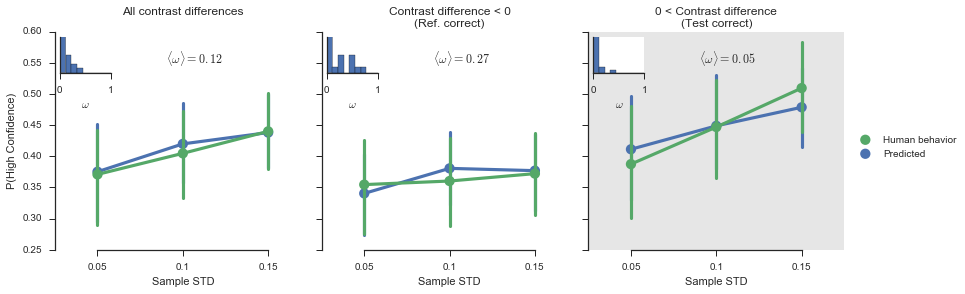

In [466]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

g = sns.factorplot(x='noise_sigma', y='data', hue='empirical', unit='ssnum', col='type', data=df, 
                  legend=False, col_order=['all', 'neg', 'pos'])

g.set_ylabels('P(High Confidence)')
g.set_xlabels('Sample STD')
g.axes[0][1].set_title('Contrast difference < 0\n(Ref. correct)')


w0 = df.query('type=="neg"').w
g.axes[0][1].text(.8, 0.55, r'$\langle\omega\rangle=%2.2f$'%(w0.mean()), fontsize=12)
ia = inset_axes(g.axes[0][1],
                        width="20%", # width = 30% of parent_bbox
                        height=.5, # height : 1 inch
                        loc=2)
ia.set_yticks([])
ia.set_xticks([0, 1])
ia.set_xlabel(r'$\omega$')
ia.hist(w0, linspace(0, 1, 10))
sns.despine(left=True, ax=ia)


w0 = df.query('type=="all"').w
g.axes[0][0].text(.8, 0.55, r'$\langle\omega\rangle=%2.2f$'%(w0.mean()), fontsize=12)
print g.axes[0][0]
ia = inset_axes(g.axes[0][0],
                        width="20%", # width = 30% of parent_bbox
                        height=.5, # height : 1 inch
                        loc=2)

ia.set_yticks([])
ia.set_xticks([0, 1])
ia.set_xlabel(r'$\omega$')
ia.hist(w0, linspace(0, 1, 10))
sns.despine(left=True, ax=ia)

w0 = df.query('type=="pos"').w
g.axes[0][2].text(.8, 0.55, r'$\langle\omega\rangle=%2.2f$'%(w0.mean()), fontsize=12)
ia = inset_axes(g.axes[0][2],
                        width="20%", # width = 30% of parent_bbox
                        height=.5, # height : 1 inch
                        loc=2)
ia.set_yticks([])
ia.set_xticks([0, 1])
ia.set_xlabel(r'$\omega$')
ia.hist(w0, linspace(0, 1, 10))
print ia.get_xlim()
sns.despine(left=True, ax=ia)

g.axes[0][2].add_patch(Rectangle((-0.5, .0) , 3, 1, color=(.9, .9, .9), zorder=-1))

g.axes[0][0].set_title('All contrast differences\n ')
g.axes[0][2].set_title('0 < Contrast difference\n(Test correct)')
g.add_legend(title='')
sns.despine(trim=True)
savefig('/Users/nwilming/u/conf_analysis/plots/variance_misperception.pdf', bbox_inches='tight')

In [441]:
print 'Running binomial test to check whether $\omega$ decreases or stays equal for neg'
kd = df.query('empirical=="Predicted" & noise_sigma==0.05 & ~(type=="all")')
kd = pd.pivot_table(index='ssnum', columns='type', values='w', data=kd)
vals = diff(kd.values).ravel()
print len(vals)
from scipy.stats import binom_test
print binom_test(sum(vals<=0), len(vals))

Running binomial test to check whether $\omega$ decreases or stays equal for neg
15
0.00738525390625


In [ ]:
from scipy.stats.binom_test

In [395]:
from scipy.stats import ttest_1samp
# Do a repeated measures ANOVA in R using ezANOVA

edges = arange(-1.75, 1.76, 0.5)
print edges
kd = df.query('empirical=="Predicted" & noise_sigma==0.05 & ~(type=="all")')
kd.loc[:, 'snum'] = 'S' + kd.ssnum.astype(str)
kd.loc[:, 'wtrans'] = tanh(2*(kd.loc[:, 'w']-0.5))
kd.to_csv('/Users/nwilming/kernels2.csv')

print kd.head()

print 'RM ANOVA in R:'
import rpy2.robjects as robjects
R_cmd = '''
library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
ezANOVA(df2, wtrans, wid=snum, within=.(type))
'''

print 'RM ANOVA:'
print robjects.r(R_cmd)
print 


[-1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75]
   noise_sigma      data  ssnum type     w  empirical snum    wtrans
0         0.05  0.353383      1  neg  0.26  Predicted   S1 -0.446244
0         0.05  0.299349      1  pos  0.00  Predicted   S1 -0.761594
0         0.05  0.141509      2  neg  0.00  Predicted   S2 -0.761594
0         0.05  0.361949      2  pos  0.18  Predicted   S2 -0.564900
0         0.05  0.563008      3  neg  0.46  Predicted   S3 -0.079830
RM ANOVA in R:
RM ANOVA:
$ANOVA
  Effect DFn DFd        F          p p<.05       ges
2   type   1  14 7.529981 0.01582784     * 0.2397647





In [354]:
df.head()

,noise_sigma,data,ssnum,type,w,empirical
0,0.05,0.327907,1,all,0.13,Predicted
1,0.10,0.372236,1,all,0.13,Predicted
2,0.15,0.364954,1,all,0.13,Predicted
0,0.05,0.353383,1,neg,0.26,Predicted
1,0.10,0.347826,1,neg,0.26,Predicted


(-0.25, 2.75)

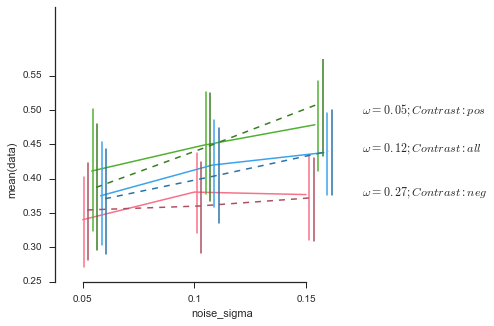

In [310]:
df.groupby('type').w.mean()

colors = sns.husl_palette(3)

for i, t in enumerate(['all', 'pos', 'neg'][::-1]):
    palette = {0: colors[i], 1:[x*0.7 for x in colors[i]]}
    subset = df.query('type=="%s"'%t)
    #subset.loc[:, 'noise_sigma'] += i*0.01
    g = sns.pointplot(x='noise_sigma', y='data', hue='empirical', unit='snum', data=subset, 
                  dodge=0.0, palette=palette, linestyles=['-', '--'], markers='', legend=False,
                   ax=gca())

    w = subset.w.mean()
    y = df.query('type=="%s" & noise_sigma==0.15'%t).data.mean()
    text(2.5, y, r'$\omega=%2.2f; Contrast: %s$'%(w,t), fontsize=12)


for j, a in enumerate(gca().lines):
    a.set_linewidth(1.5)
    x, y = a.get_data()
    a.set_data((x+(j*0.01), y))    
    
legend('')
#sns.pointplot(x='noise_sigma', y='predicted', hue='set', unit='snum', data=df)

sns.despine(trim=True)
ylim([0.25, 0.575])
xlim([-0.25, 2.75])

In [280]:
a.get_data()

(array([ 2.,  2.]), array([ 0.37860752,  0.50138446]))

In [216]:
print w.ravel()[argmin(r_all.ravel())]
print w.ravel()[argmin(rneg.ravel())]
print w.ravel()[argmin(rpos.ravel())]

0.03
0.25
0.0


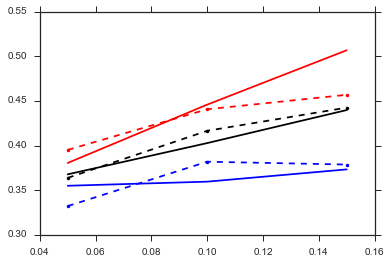

In [217]:
plot([0.05, 0.1, 0.15], target_all, 'k')
plot([0.05, 0.1, 0.15], predicted_all, 'k.--')
plot([0.05, 0.1, 0.15], targetneg, 'b')
plot([0.05, 0.1, 0.15], predictedneg, 'b.--')
plot([0.05, 0.1, 0.15], targetpos, 'r')
plot([0.05, 0.1, 0.15], predictedpos, 'r.--')

In [20]:
ws = [params.loc[snum, :].w.values[0] for snum in range(1, 15)]
sub_order = argsort(ws)

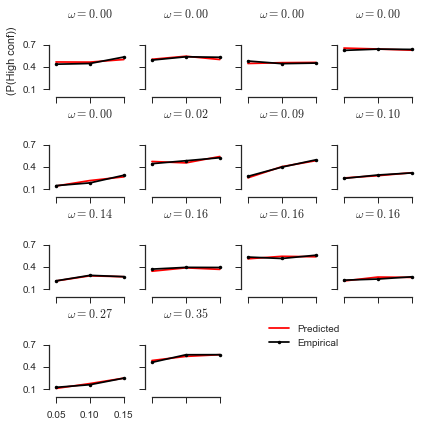

In [21]:
figure(figsize=(6,6))

for i, sub in enumerate(sub_order):
    subd,  p = dz.query('snum==%i'%(sub+1)), params.loc[sub+1]
    subplot(4, 4, i+1)
    predicted = p.predicted.values[0]
    target = p.target.values[0]
    plot([0.05, 0.1, 0.15], predicted, 'r', label='Predicted')
    plot([0.05, 0.1, 0.15], target, 'k.-', label='Empirical')
    if i == 0:
        ylabel(r'(P(High conf))')
    if i == 12:
        xticks([.05, .1, .15])
    else:
        xticks([.05, .1, .15], [])
    if mod(i, 4)==0:
        yticks([0.1, 0.4, 0.7])
    else:
        yticks([0.1, 0.4, 0.7], [])
    ylim([0.0, 1])
    title(r'$\omega=%2.2f$'%round(ws[sub], 3))
sns.despine(trim=True)
legend(bbox_to_anchor=(2.5, 1.1))
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/variance_misperceptiont.pdf', bbox_inches='tight')

In [35]:
params_time = dz.groupby(['snum', 'session_num']).apply(foo)

In [22]:
dz.loc[:, 'IDblock'] = (dz.session_num*5) + dz.block_num

In [ ]:
figure(figsize=(5, 2.5))
tt = params_time.reset_index().pivot_table(index='session_num', columns='snum', values='w')
#print tt
sem = tt.std(1)/(tt.shape[0]**.5)
plot(arange(len(sem))+1, tt, 'k', alpha=0.25)
errorbar(arange(len(sem))+1, tt.mean(1), yerr=1*sem, lw=4.5)

#xlim([0.99, 5.01])
sns.despine(offset=5)


In [ ]:
print params.w
print mean(params.w.values), std(params.w.values)


In [26]:
params_pos = dz.query('mc>0').groupby(['snum']).apply(foo)

In [27]:
params_neg = dz.query('mc<0').groupby(['snum']).apply(foo)

In [39]:
ws = dict((snum, params.loc[snum, :].w.values[0]) for snum in range(1, 15))
ws_pos = dict((snum, params_pos.loc[snum, :].w.values[0]) for snum in range(1, 15))
ws_neg = dict((snum, params_neg.loc[snum, :].w.values[0]) for snum in range(1, 15))
sub_order = sorted(ws, key=ws.get, reverse=True)

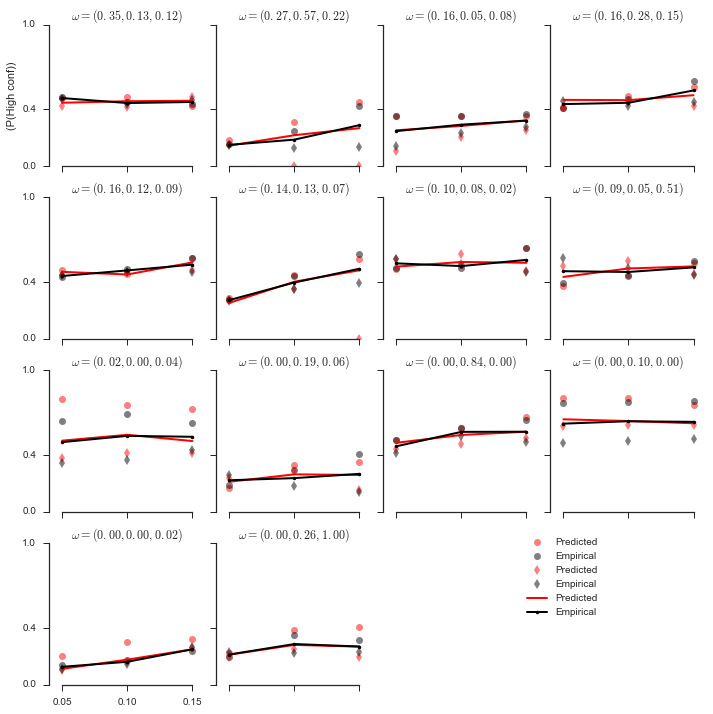

In [52]:
figure(figsize=(10,10))

for i, sub in enumerate(sub_order):
    p = params.loc[sub+1]
    p_pos, p_neg = params_pos.loc[sub+1], params_neg.loc[sub+1]
    subplot(4, 4, i+1)
    predicted = p_pos.predicted.values[0]
    target = p_pos.target.values[0]
    plot([0.05, 0.1, 0.15], predicted, 'ro', label='Predicted', alpha=0.5)
    plot([0.05, 0.1, 0.15], target, 'ko', label='Empirical', alpha=0.5)
    
    predicted = p_neg.predicted.values[0]
    target = p_neg.target.values[0]
    plot([0.05, 0.1, 0.15], predicted, 'rd', label='Predicted', alpha=0.5)
    plot([0.05, 0.1, 0.15], target, 'kd', label='Empirical', alpha=0.5)
    
    
    predicted = p.predicted.values[0]
    target = p.target.values[0]
    plot([0.05, 0.1, 0.15], predicted, 'r-', label='Predicted', lw=2)
    plot([0.05, 0.1, 0.15], target, 'k.-', label='Empirical', lw=2)
    
    if i == 0:
        ylabel(r'(P(High conf))')
    if i == 12:
        xticks([.05, .1, .15])
    else:
        xticks([.05, .1, .15], [])
    if mod(i, 4)==0:
        yticks([0, 0.4, 1])
    else:
        yticks([0, 0.4, 1], [])
    ylim([0.0, 1])
    
    title(r'$\omega=(%2.2f, %2.2f, %2.2f)$'%(round(ws[sub], 3), round(ws_pos[sub], 3), round(ws_neg[sub], 3)))
sns.despine(trim=True)
legend(bbox_to_anchor=(2.5, 1.1))
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/variance_misperceptiont_mc_plus.pdf', bbox_inches='tight')

In [45]:
dz.loc[:, 'conf_0index'] = dz.confidence==2

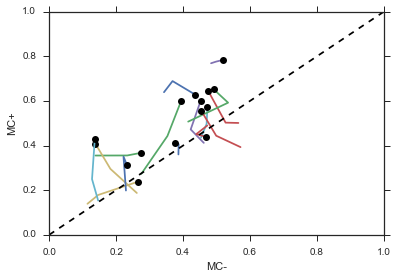

In [50]:
for snum, sd in dz.groupby('snum'):
    plot(sd.query('mc<0').groupby('noise_sigma').conf_0index.mean().values,
        sd.query('mc>0').groupby('noise_sigma').conf_0index.mean().values)
    plot(sd.query('mc<0').groupby('noise_sigma').conf_0index.mean().values[-1],
        sd.query('mc>0').groupby('noise_sigma').conf_0index.mean().values[-1], 'ko')
plot([0, 1], [0, 1], 'k--')
xlabel('MC-')
ylabel('MC+')

In [61]:
p_pos = foo(dz.query('mc>0'))
p_neg = foo(dz.query('mc<0'))

In [63]:
p_all = foo(dz)

In [176]:
print p_pos.w
print p_neg.w
print p_all.w

0    0.26
Name: w, dtype: float64
0    0.06
Name: w, dtype: float64
0    0.02
Name: w, dtype: float64


[array([ 0.37889383,  0.4628274 ,  0.49800995])]


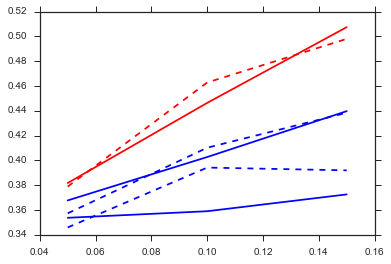

In [177]:
p = Out[54] 
print p.predicted.values
plot([0.05, 0.1, 0.15], p_pos.predicted.values[0], 'r--')
plot([0.05, 0.1, 0.15], p_pos.target.values[0], 'r')


plot([0.05, 0.1, 0.15], p_neg.predicted.values[0], 'b--')
plot([0.05, 0.1, 0.15], p_neg.target.values[0], 'b')

plot([0.05, 0.1, 0.15], p_all.predicted.values[0], 'b--')
plot([0.05, 0.1, 0.15], p_all.target.values[0], 'b')

In [170]:
colors = sns.husl_palette(3)
x = array([0.05, 0.1, 0.15])
df = []

for i, ps in enumerate([params, params_pos, params_neg]):
    sn = tile(ps.index.get_level_values('snum'), (3, 1)).T
    pr = vstack(ps.predicted.values)
    tg = vstack(ps.target.values)
    ns = tile([0.05, 0.1, 0.15], (15, 1))
    w = tile(ps.loc[:, 'w'], (3, 1)).T
    df.append(pd.DataFrame({'set':i, 'snum': sn.ravel(), 
                            'type':0, 'data':pr.ravel(), 'noise_sigma':ns.ravel(),
                             'w': w.ravel()}))
    df.append(pd.DataFrame({'set':i, 'snum': sn.ravel(), 
                            'type':1, 'data':tg.ravel(), 'noise_sigma':ns.ravel(),
                            'w':w.ravel()}))
df = pd.concat(df)

0.167333333333
0.186666666667
0.108


(0.2, 0.6)

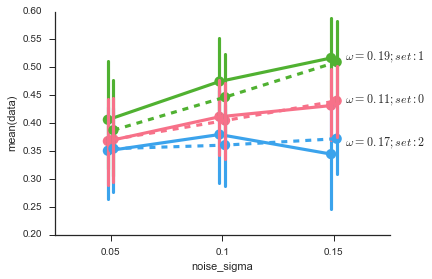

In [178]:
colors = sns.husl_palette(3)
p_list = [params, params_pos, params_neg]
for s in [2,1,0]:
    palette = {0: colors[s], 1:colors[s]}
    ax = sns.pointplot(x='noise_sigma', y='data', hue='type', unit='snum', data=df.query('set==%i'%s), 
                  dodge=True, palette=palette, linestyles=['-', '--'], legend=False)
    w = df.query('set==%i'%s).w.mean()
    print w
    y = df.query('set==%i & noise_sigma==0.15'%s).data.mean()
    text(2.1, y, r'$\omega=%2.2f; set: %i$'%(w,s), fontsize=12)

ax.legend('')
#sns.pointplot(x='noise_sigma', y='predicted', hue='set', unit='snum', data=df)

sns.despine()
ylim([0.2, 0.6])